In [12]:

import jax.numpy as jnp

import sys
sys.path.insert(1,'..')

import utils
import loader

%load_ext autoreload
%autoreload 2

import setup


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:

params = {
    'file': '../data/',
    'tag': '2022_Q2_IBL_et_al_RepeatedSite',
    'probe': 'probe00',
    # 'sessions': [5,6,7,8,9,10,11,12],
    'areas': ['CA1','DG','LP','PO','VISa'],
    'props':{'train':.5,'test':.5,'validation':0},
    'seeds':{'train':0,'test':1,'validation':2},
    'n_neurons': None, # all neurons
    'n_trials': None, # all trials
    'pre_time':-.2,
    'post_time':.4,
    'n_bins': 2,
    'align_to': 'response',
    'train_trial_prop':.9, 
    'train_condition_prop':1, 
    'seed':0,
    'verbose': True
}

dataloader = loader.IBLDataLoader(
    params,eids=setup.good_eids,parallel=True
)

xs,ys,rs,cs = dataloader.load_train_data()


2024-07-15 14:48:57,336	INFO worker.py:1621 -- Calling ray.init() again after it has already been called.


In [17]:
jnp.array([y.shape for y in ys]).min(0)

Array([ 11,  18, 154], dtype=int32)

In [18]:
min_neurons = 100
min_trials = 10

valid = [i for i in range(len(ys)) if ys[i].shape[2] >= min_neurons and ys[i].shape[0] >= min_trials]
ys = [ys[i] for i in valid]

n_trials = min([y.shape[0] for y in ys])
n_neuorns = min([y.shape[2] for y in ys])

# Selection based on variance across trials
ys = jnp.stack([y[:min_trials,:,jnp.argsort(y.mean(0).std(0))[:min_neurons]] for y in ys])


In [19]:
print('Subjects: {}, Trials:{}, Conditions:{}, Neurons:{}'.format(*ys.shape))

S,K,C,N = ys.shape


Subjects: 33, Trials:10, Conditions:18, Neurons:100


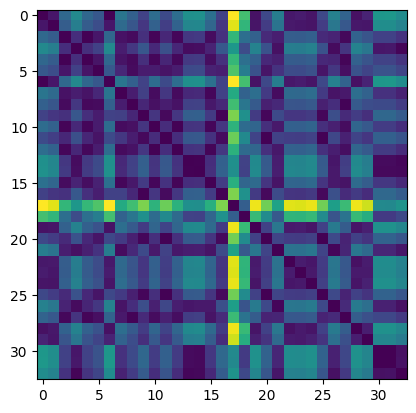

In [24]:
dist_neural = utils.dsd([
    [ys[i].mean(0),ys[j].mean(0)]
     for i in range(len(ys)) 
     for j in range(len(ys))]
).reshape(S,S)


import matplotlib.pyplot as plt
plt.imshow(dist_neural)

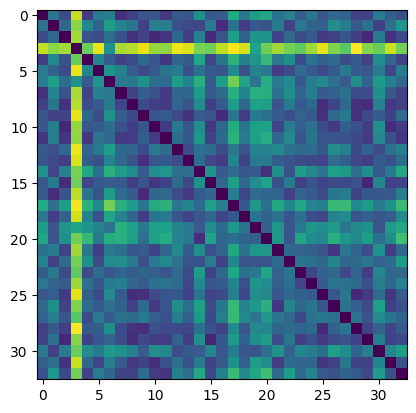

In [44]:
dist_cc = utils.dsd([
    [cs[i].mean(0)[:,None],cs[j].mean(0)[:,None]]
     for i in range(len(cs)) 
     for j in range(len(cs))]
).reshape(len(cs),len(cs))

import matplotlib.pyplot as plt
plt.imshow(dist_cc)

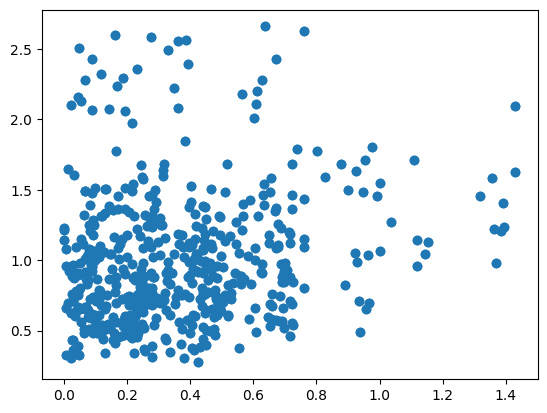

In [47]:
plt.scatter(
    dist_neural[~jnp.eye(dist_neural.shape[0],dtype=bool)],
    dist_cc[~jnp.eye(dist_cc.shape[0],dtype=bool)],
)
plt.show()

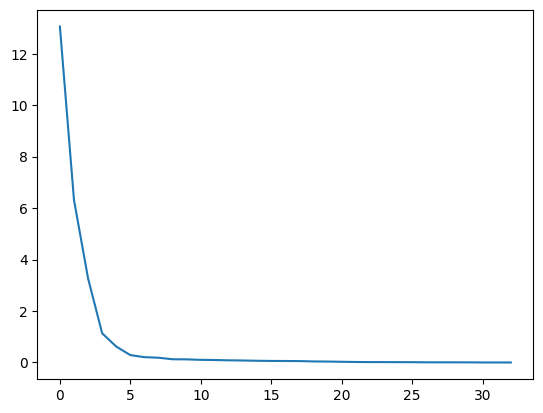

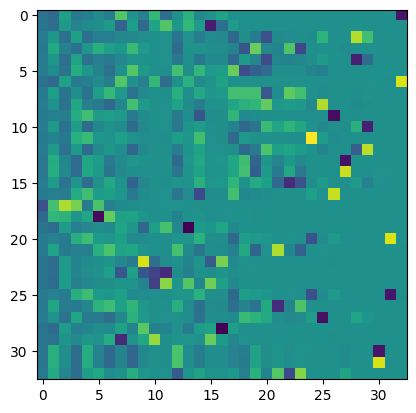

In [31]:
U,S,Vh = jnp.linalg.svd(dist_neural)
plt.plot(S)
plt.show()
plt.imshow(U[])
plt.show()